# Trined Model Evalution

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/chest-x-ray-diagnosis'

In [2]:
# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from hydra import compose, initialize

from src.utils.utils import plot_auc_curve
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor
from src.weighted_loss.weighted_loss import get_weighted_loss

2025-03-19 11:29:55.337455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742383795.350598  190850 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742383795.355087  190850 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR)

datasets/sample/sample/images


In [4]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

In [5]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [6]:
CLASSES_NAME = ['Atelectasis','Effusion','Infiltration', 'Mass']#,'Nodule']

## Loading Data

In [7]:
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor

test_prorcessor  = ChestXRayPreprocessor(cfg, labels=CLASSES_NAME)
test_prorcessor.get_training_and_validation_datasets()
test_ds = test_prorcessor.get_test_dataset()

2025-03-19 11:29:59,758 — src.data_loader.chest_x_ray_preprocessor — INFO — Getting training and validation datasets with batch size:None
2025-03-19 11:29:59,759 — src.data_loader.chest_x_ray_preprocessor — INFO — Loading and preprocessing dataframe
2025-03-19 11:29:59,766 — src.data_loader.chest_x_ray_preprocessor — INFO — Cleaning up training dataframe
2025-03-19 11:29:59,788 — src.data_loader.chest_x_ray_preprocessor — INFO — Loaded dataframe with shape: (5606, 2) and 5606 rows
2025-03-19 11:29:59,823 — src.data_loader.chest_x_ray_preprocessor — INFO — training split: 4036 and validation split: 1009


I0000 00:00:1742383799.740360  190850 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7300 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


2025-03-19 11:30:03,264 — src.data_loader.chest_x_ray_preprocessor — INFO — Preparing training dataset with augmentation
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-19 11:30:03,675 — src.data_loader.chest_x_ray_preprocessor — INFO — Augmenting image
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-19 11:30:05,159 — src.data_loader.chest_x_ray_preprocessor — INFO — Augmenting image
2025-03-19 11:30

In [8]:
for batch in test_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(32, 320, 320, 1) (32, 4)
(320, 320, 1) -2.025388 1.8876557 tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


## Load the Trained model 

In [9]:
tf_model = tf.keras.saving.load_model('exported_models/ckpt_31.keras')
# tf_model.summary()

In [10]:
y_pred = tf_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)
y_pred

I0000 00:00:1742383859.118799  190986 cuda_dnn.cc:529] Loaded cuDNN version 90701


18/18 [==============================] - 4s 95ms/step


array([[0, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       ...,
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0]])

In [11]:
import numpy as np


y_true = np.array([y.astype(int) for _, y in test_ds.unbatch().as_numpy_iterator()])
y_true

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       ...,
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 0]])

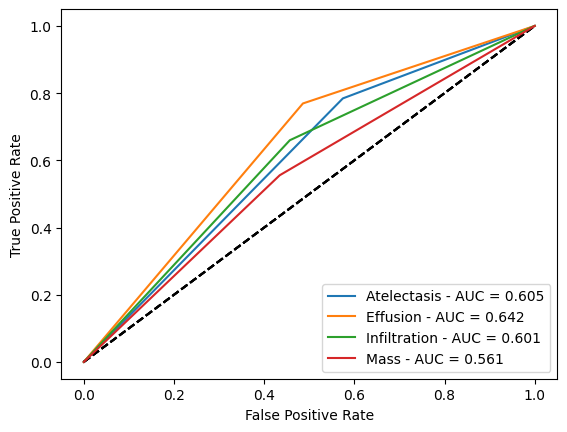

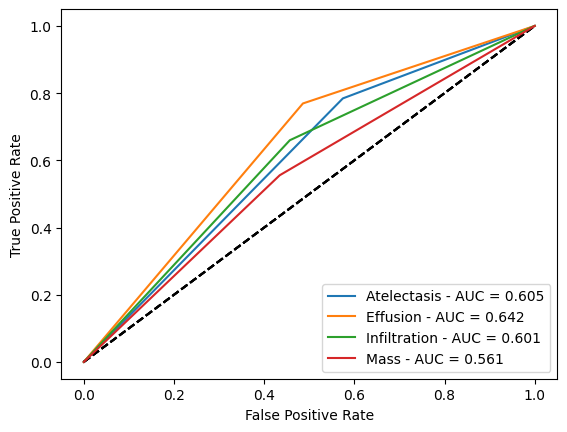

In [12]:
plot_auc_curve(output_dir='resources', 
               class_name_list=CLASSES_NAME, 
               y_true=y_true, 
               y_prob_pred=y_pred)

In [13]:
model_uri = 'runs:/41f62d63ef8745f5a758cd22615cf7da/my_model'
# The model is logged with an input example
mlflow_model =mlflow.tensorflow.load_model(model_uri)

In [14]:
y_pred_pyfunc = mlflow_model.predict(test_ds)
y_pred_pyfunc = (y_pred_pyfunc > 0.5).astype(int)
y_pred_pyfunc

18/18 [==============================] - 3s 59ms/step


array([[1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       ...,
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0]])

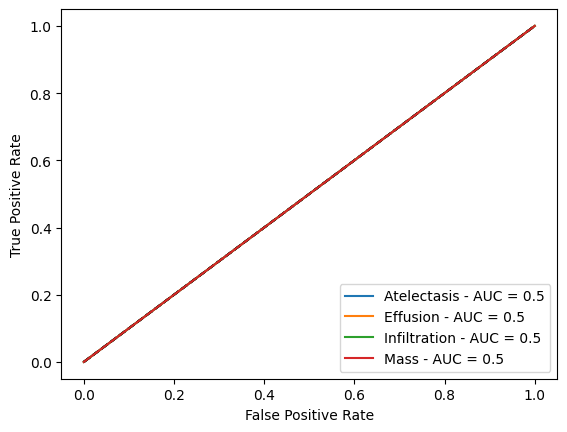

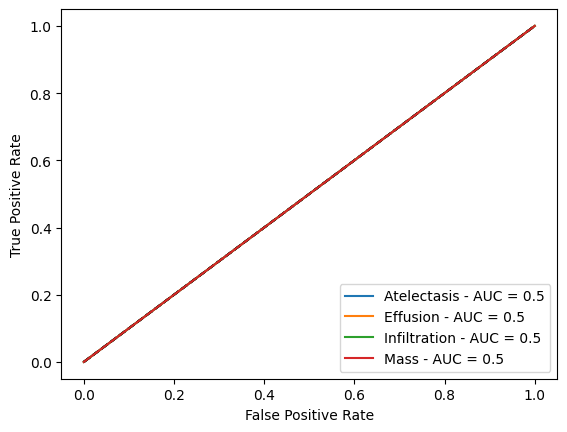

In [15]:
plot_auc_curve(output_dir='resources', 
               class_name_list=CLASSES_NAME, 
               y_true=y_true, 
               y_prob_pred=y_pred_pyfunc)

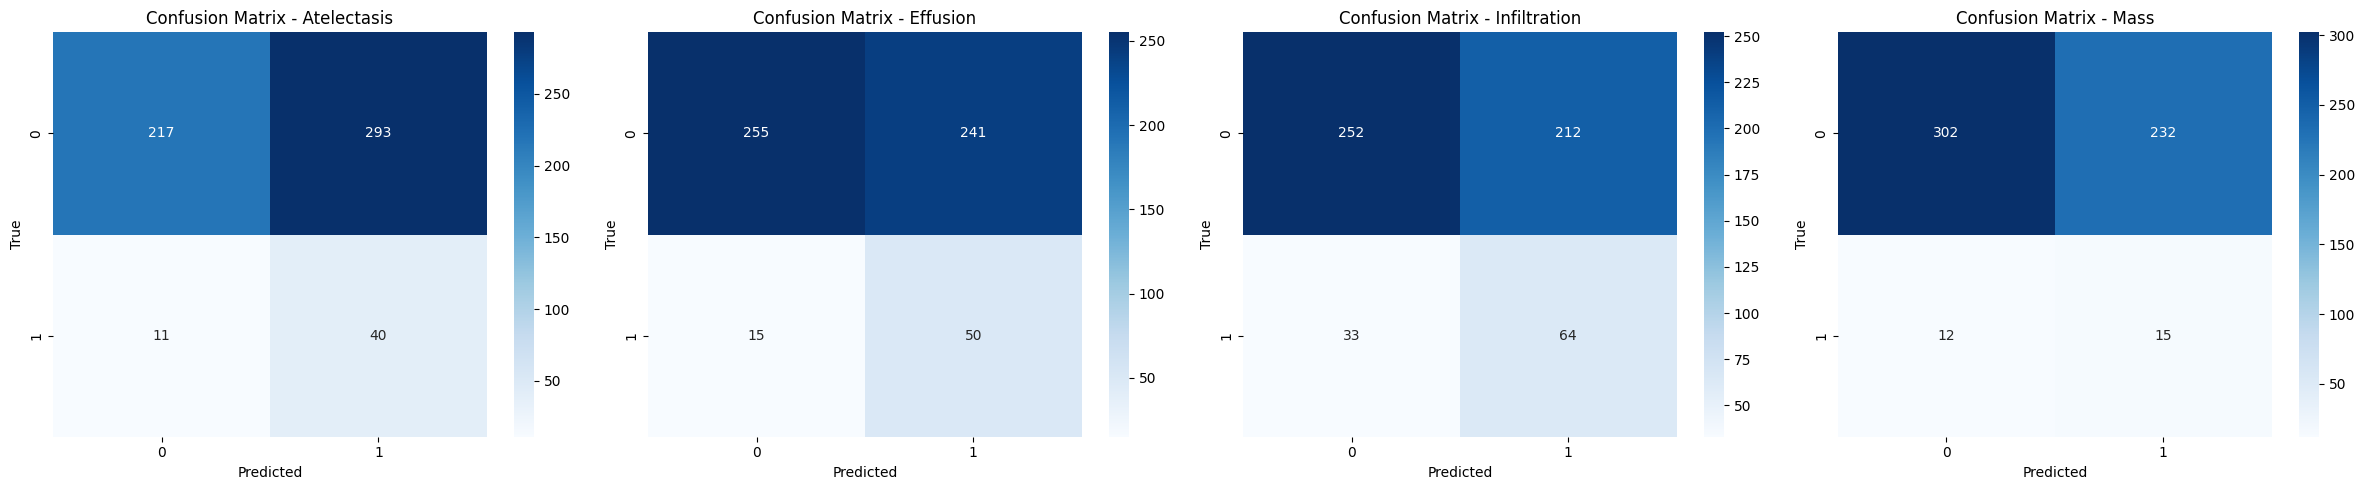

In [22]:
# Multi-label Confusion Matrix
from sklearn.metrics import confusion_matrix

num_classes = len(CLASSES_NAME)
fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 6, 5))
for i, class_label in enumerate(CLASSES_NAME):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - {class_label}')

plt.tight_layout()
plt.show()
# mlflow.log_figure(fig, 'confusion_matrices.png')
plt.close(fig)

In [17]:
  # Ensure the dataset is shuffled (if it's not already)
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())

  # Take a batch of images and labels
test_images = []
test_labels = []
for images, labels in test_ds:
    for image, label in zip(images, labels):
        test_images.append(image)
        test_labels.append(label)


In [18]:
def plot_random_images(test_images, test_labels, num_images=9):
  """
  Plots a random sample of images and their corresponding labels from a TensorFlow dataset.

  Args:
    train_ds: A TensorFlow dataset object containing image-label pairs.
    num_images: The number of images to plot (default: 9).
  """



  # Create a figure and axes for the plot
  plt.figure(figsize=(10, 10))

  # Iterate through the images and plot them
  for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1) # Create a grid of subplots
    plt.imshow(test_images[i].numpy().astype("uint8"), cmap='gray') # Convert to numpy and uint8 for display
    lab_np = test_labels[i].numpy()
    pred_indices = np.where(lab_np==1)[0]
    if len(pred_indices) == 0:
       class_names='None'
    else:
      class_names = '-'.join([CLASSES_NAME[i] for i in pred_indices])
    plt.title(f"{class_names}") # Display the label
    plt.axis("off") # Hide the axes

  plt.tight_layout()
  plt.show()

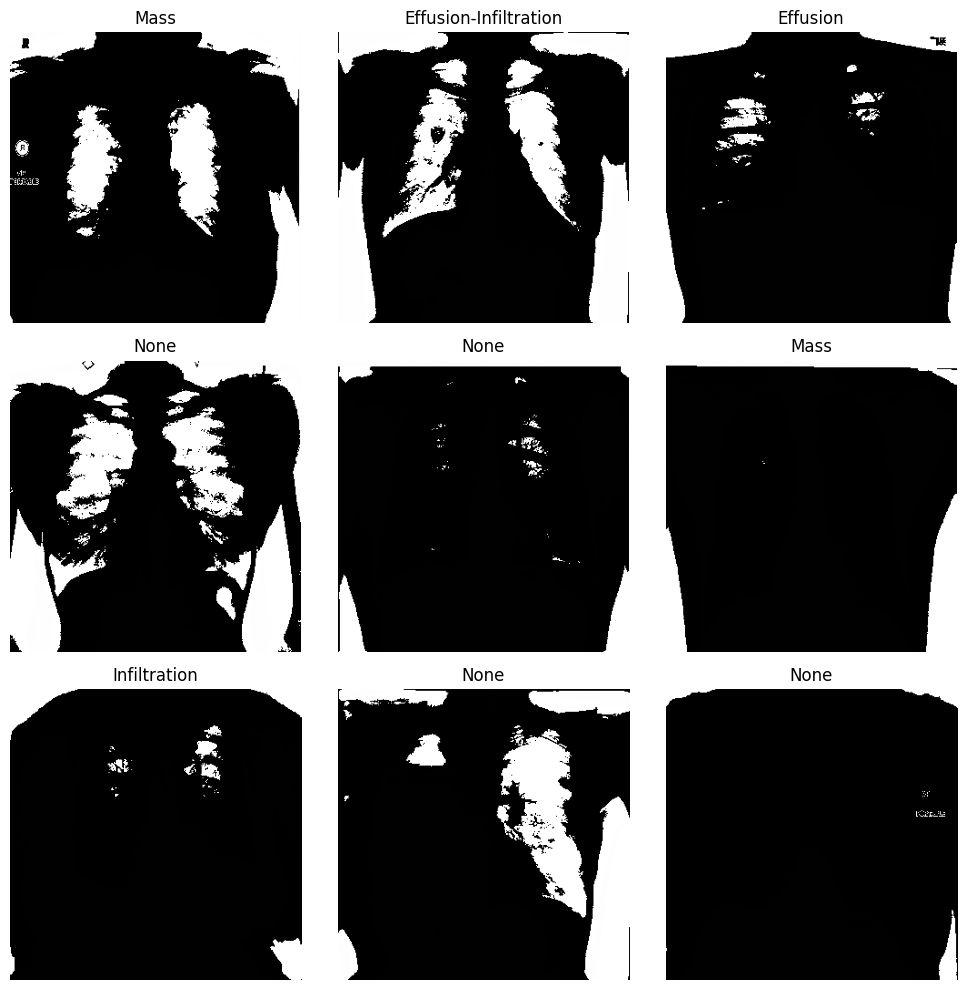

In [19]:
plot_random_images(test_images, test_labels, num_images=9)

In [20]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_model(*,model:tf.keras.Model, 
                   test_ds:tf.data.Dataset, 
                   y_true_labels:np.ndarray, 
                   output_dir:Path,
                   class_name:list[str]) -> None:
    """Evaluates the model.

    Args:
        model: The model to evaluate.
        test_ds: The test dataset.
        y_true_labels: The true labels.
        y_true_bboxes: The true bounding boxes.
        cfg: The configuration object.
        class_name: The list of class names.
    """
    # log = get_logger(__name__)
    # log.info("Evaluating model...")
    print('ddfdf')
    results = model.evaluate(test_ds, return_dict=True)
    # mlflow.log_dict(results, 'test_metrics.json')
    y_prob_pred = model.predict(test_ds)

    y_pred = (y_prob_pred>0.5).astype(int)

    report = classification_report(y_true_labels,
                                    y_pred, 
                                    labels=[0,1,2], 
                                    target_names=class_name,
                                    output_dict=True)
    print(report)
    # mlflow.log_dict(report, 'classification_report.json') 

    auc_fig = plot_auc_curve(output_dir=output_dir, 
               class_name_list=class_name, 
               y_true=y_true, 
               y_prob_pred=y_pred)
    # auc_fig = plot_auc_curve(output_dir, class_name, y_true_labels, y_prob_pred)
    mlflow.log_figure(auc_fig, 'ROC-Curve.png')

    # log.info("Model evaluated.")

In [21]:
evaluate_model(model=tf_model, 
                test_ds=test_ds, 
                y_true_labels=y_true, 
                output_dir=cfg.OUTPUTS.OUPUT_DIR,
                class_name=CLASSES_NAME) 

ddfdf


TypeError: in user code:

    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 2063, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 2046, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 2034, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1916, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1206, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/losses.py", line 161, in __call__
        return losses_utils.compute_weighted_loss(
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/utils/losses_utils.py", line 327, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Failed to convert elements of <function outer_factory.<locals>.inner_factory.<locals>.tf__get_weighted_loss.<locals>.weighted_loss at 0x76e704c8d6c0> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
